# ***Lineer Regresyon ile Tahmin***

## ***Konut Fiyatlari***

Ev Fiyatları verilerini [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)'dan indirin.

- Verilerinizi eğitim ve test kümelerine ayırın.

- Modelinizi eğitim kümesinden önceki derste olduğu gibi oluşturun. Modelinizin uygunluğunu değerlendirin.

- Test kümesindeki ev fiyatlarını tahmin edin ve bu derste belirttiğimiz metrikleri kullanarak modelinizin performansını değerlendirin. Modelinizin performansı tatmin edici mi? Açıklayın.

- Bazı değişkenleri ekleyerek veya çıkararak modelinizi tahmin performansı açısından geliştirmeye çalışın.

---

In [17]:
import pandas as pd
import numpy as np
# grafiksel araclar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# lineer regresyon icin
from sklearn import linear_model
import statsmodels.api as sm
# polynomial features icin
from sklearn.preprocessing import PolynomialFeatures
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# tahmin performansi icin
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
# regularizasyon icin
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# path ile calismak icin
import sys
# dosyanin bulundugu dizini path e ekledik
mylib = '/home/admin1/datascience/datascience/library'
if mylib not in sys.path:
    sys.path.insert(1, mylib)
# parser i kullanabilmek icin
from data_description_parser import data_description_house_prices
data_dict = data_description_house_prices()

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}

# temiz veri setini dataframe icerisine yukle (outlierlarin bir kismi temizlenmis)
house_prices = pd.read_csv('data/house_prices_out.csv',index_col='Id')

- Sonuclar dataframe olusturularak kaydedilecek.

In [18]:
# sonuclari tutacak df
results_df = pd.DataFrame(columns=['description', 'rsquared','MAE', 'MSE', 'RMSE', 'MAPE'])
results_df.index.name = 'model' 

- Fonksiyon tanimlamalari

In [19]:
# sonuclari kaydeden fonksiyon
def save_results(results, model_nu, y_test, y_test_pred, description):
    # global degiskeni degistirmek istiyorsak fonksiyon icersinde bu tanimlama olmali
    global results_df
    new = 0
    # model_nu varsa ustune yaz yoksa yeni olustur concat et
    if ((results_df.index == model_nu).any()):        
        df = results_df
    else:
        df = pd.DataFrame([])
        df.index.name = 'model'
        new = 1
    df.loc[model_nu,'description'] = description
    df.loc[model_nu,'rsquared'] = results.rsquared
    df.loc[model_nu,'MAE'] = mean_absolute_error(y_test, y_test_pred)
    df.loc[model_nu,'MSE'] = mse(y_test, y_test_pred)
    df.loc[model_nu,'RMSE'] = rmse(y_test, y_test_pred)
    df.loc[model_nu,'MAPE'] = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100 
        
    if new == 1:        
        results_df = pd.concat([results_df, df])
        
        
# tahmin ve gercek deger grafigini cizdiren fonksiyon  
def make_plot(y_test, y_test_pred, y_train, y_train_pred):   
    plt.figure(dpi = 100)
    # gercek degerler ve tahmin degerleri
    # egitim tahminleri
    plt.scatter(y_train, y_train_pred, label='train')
    # test tahminleri
    plt.scatter(y_test, y_test_pred, label='test', alpha=0.7)
    # gercek degerlerin cizgisi
    plt.plot(y_test, y_test, color="red")
    plt.xlabel("Gerçek Değerler", fontdict=axis_font)
    plt.ylabel("Tahmin edilen Değerler", fontdict=axis_font)
    # rmse degerlerini annotate ile grafige yazabiliriz
    plt.annotate('RMSE test  : {:.2f}'.format(rmse(y_test,y_test_pred)), xy=(600000,200000))
    plt.annotate('RMSE train : {:.2f}'.format(rmse(y_train,y_train_pred)), xy=(600000,100000))
    plt.title("Satis Fiyati: Gerçek ve tahmin edilen değerler", fontdict=title_font)
    # legend lokasyonunu belirler
    plt.legend(loc='upper left')
    plt.show()

### ***1. Model (Numerik degiskenlerle)***

- Numerik degiskenleri ayiralim. SalePrice ayrildiktan sonra toplam 36 adet numerik degisken mevcut.

Eğitim kümesindeki gözlem sayısı : 1153
Test kümesindeki gözlem sayısı   : 289


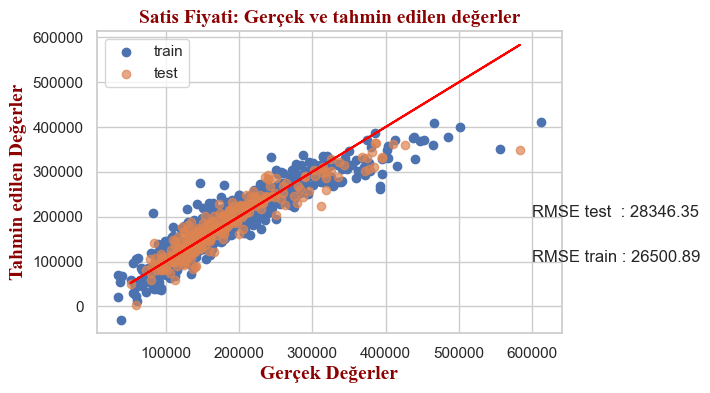

,description,rsquared,MAE,MSE,RMSE,MAPE
model,,,,,,
1,numerik degiskenler,0.867,"19,466.031","803,515,580.766","28,346.350",11.471


In [20]:
numeric_vars = [var for var in house_prices.columns if house_prices[var].dtype != 'object']
numeric_vars.remove('SalePrice')
len(numeric_vars)

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[numeric_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()

# test verisi ile tahmin
X_test = sm.add_constant(X_test)
Y_test_pred = results.predict(X_test)
# egitim verisi ile tahmin
X_train = sm.add_constant(X_train)
Y_train_pred = results.predict(X_train)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# model sonuclarini kaydedelim
save_results(results, 1, Y_test, Y_test_pred, 'numerik degiskenler')

# model sonuclari
results_df

### ***2. Model (Yuksek korelasyonlu numerik degiskenlerle)***

Eğitim kümesindeki gözlem sayısı : 1153
Test kümesindeki gözlem sayısı   : 289


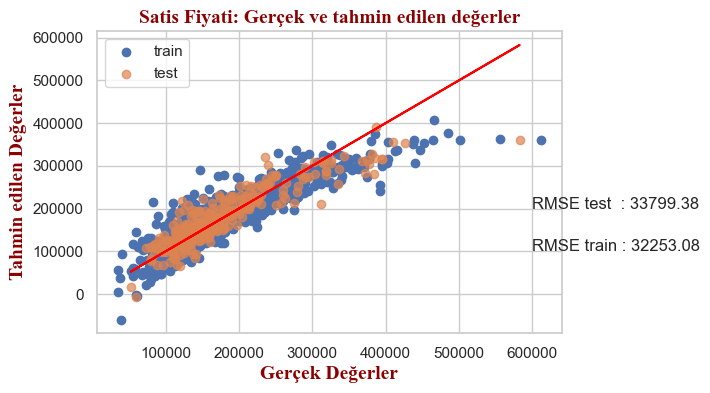

,description,rsquared,MAE,MSE,RMSE,MAPE
model,,,,,,
1,numerik degiskenler,0.867,"19,466.031","803,515,580.766","28,346.350",11.471
2,yuksek korelasyonlu numerik degiskenler,0.803,"24,447.903","1,142,398,277.057","33,799.383",14.919


In [21]:
# yuksek korelasyonlu surekli degiskenler
high_corr = ['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual']

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[high_corr]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()

# test verisi ile tahmin
X_test = sm.add_constant(X_test)
Y_test_pred = results.predict(X_test)
# egitim verisi ile tahmin
X_train = sm.add_constant(X_train)
Y_train_pred = results.predict(X_train)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# model sonuclarini kaydedelim
save_results(results, 2, Y_test, Y_test_pred, 'yuksek korelasyonlu numerik degiskenler')

# model sonuclari
results_df

### ***3. Model (Farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular)***

Eğitim kümesindeki gözlem sayısı : 1153
Test kümesindeki gözlem sayısı   : 289


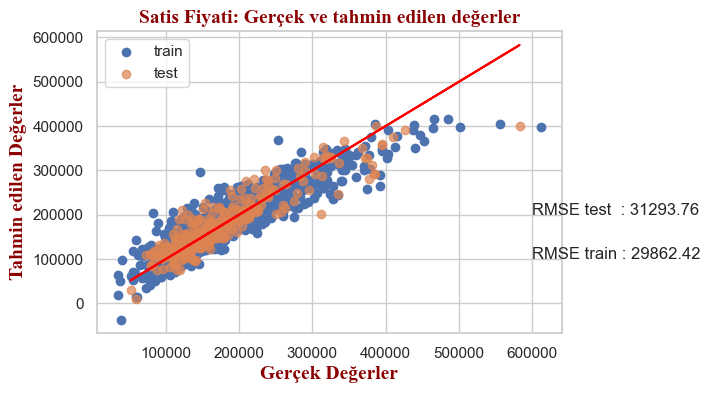

,description,rsquared,MAE,MSE,RMSE,MAPE
model,,,,,,
1,numerik degiskenler,0.867,"19,466.031","803,515,580.766","28,346.350",11.471
2,yuksek korelasyonlu numerik degiskenler,0.803,"24,447.903","1,142,398,277.057","33,799.383",14.919
3,farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular,0.832,"22,988.782","979,299,380.403","31,293.759",14.051


In [22]:
# neighborhood degiskenini encode edecek fonksiyon
def encode_neighborhood(val):
    # belirgin sekilde en yuksek fiyat ozelligi gosteren neighborhood degerleri
    if val in ['NoRidge', 'NridgHt',  'StoneBr']:
        return 1
    else:
        return 0

# encode edilen degisken ayri sutunda
house_prices['Neighborhood_e'] = house_prices['Neighborhood'].apply(encode_neighborhood)
# lambda ile 'Partial' olan evlere 1 digerlerine 0 atadik
house_prices['SaleCondition_e'] = house_prices['SaleCondition'].apply(lambda x: 
                                                                      1 if x == 'Partial' else 0)

# farklilik olusturan kategorikler eklendi
expl_vars = high_corr + ['Neighborhood_e', 'SaleCondition_e'] 

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()

# test verisi ile tahmin
X_test = sm.add_constant(X_test)
Y_test_pred = results.predict(X_test)
# egitim verisi ile tahmin
X_train = sm.add_constant(X_train)
Y_train_pred = results.predict(X_train)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# model sonuclarini kaydedelim
save_results(results, 3, Y_test, Y_test_pred, 
             'farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular')

# model sonuclari
results_df

### ***4. Model Etkilesimli(Farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular)***

Eğitim kümesindeki gözlem sayısı : 1153
Test kümesindeki gözlem sayısı   : 289


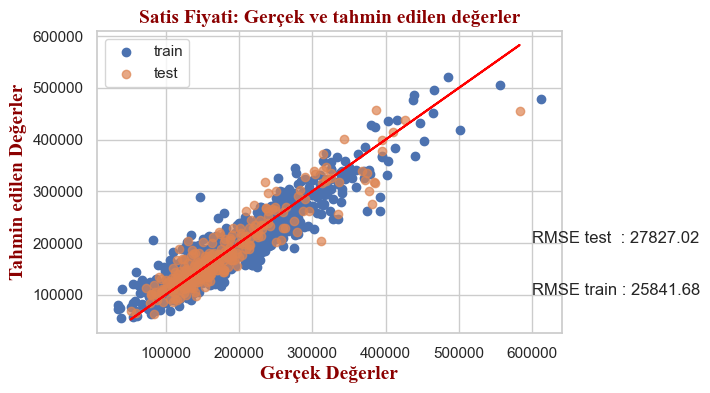

,description,rsquared,MAE,MSE,RMSE,MAPE
model,,,,,,
1,numerik degiskenler,0.867,"19,466.031","803,515,580.766","28,346.350",11.471
2,yuksek korelasyonlu numerik degiskenler,0.803,"24,447.903","1,142,398,277.057","33,799.383",14.919
3,farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular,0.832,"22,988.782","979,299,380.403","31,293.759",14.051
4,etkilesimli(farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular,0.874,"20,523.617","774,342,976.286","27,827.019",12.215


In [23]:
# farklilik olusturan kategorikler eklendi
expl_vars = high_corr + ['Neighborhood_e', 'SaleCondition_e'] 

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# kacinci dereceden polinomlar olusturacagiz belirtiyoruz
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()
# test verisi ile tahmin
X_test = sm.add_constant(X_test)
Y_test_pred = results.predict(X_test)
# egitim verisi ile tahmin
X_train = sm.add_constant(X_train)
Y_train_pred = results.predict(X_train)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# model sonuclarini kaydedelim
save_results(results, 4, Y_test, Y_test_pred,
             'etkilesimli(farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular')

# model sonuclari
results_df

### ***5. Model (Butun degiskenlerle)***

Eğitim kümesindeki gözlem sayısı : (1153, 79)
Test kümesindeki gözlem sayısı   : (289, 79)


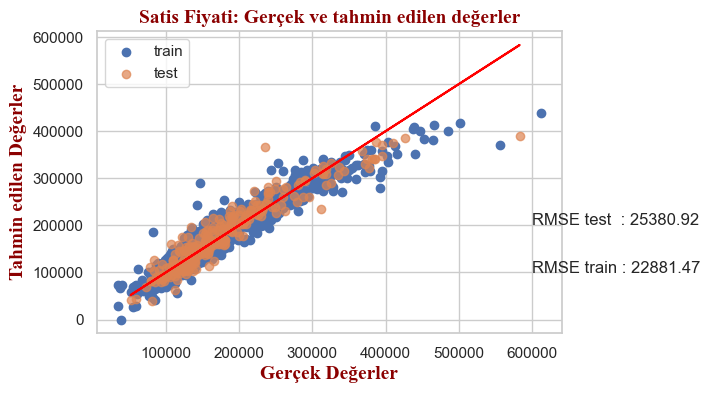

,description,rsquared,MAE,MSE,RMSE,MAPE
model,,,,,,
1,numerik degiskenler,0.867,"19,466.031","803,515,580.766","28,346.350",11.471
2,yuksek korelasyonlu numerik degiskenler,0.803,"24,447.903","1,142,398,277.057","33,799.383",14.919
3,farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular,0.832,"22,988.782","979,299,380.403","31,293.759",14.051
4,etkilesimli(farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular,0.874,"20,523.617","774,342,976.286","27,827.019",12.215
5,butun degiskenler,0.901,"17,458.344","644,190,949.454","25,380.917",10.370


In [24]:
# temiz veri setini dataframe icerisine yukle (outlierlarin bir kismi temizlenmis)
house_prices = pd.read_csv('data/house_prices_out.csv',index_col='Id')

# object tipinde olanlar kategorik degiskenler listesine ayir
qualitative = [column for column in house_prices.columns if house_prices.dtypes[column] == 'object']

# object tipinde olanlar kategorik degiskenler listesine ayir
quantitative = [column for column in house_prices.columns if house_prices.dtypes[column] != 'object']

def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    # degerler index yapildi
    ordering.index = ordering.val
    # degisken degerlerinin SalePrice ortalamalarini aliyor
    ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    # ortalamalari siraliyor
    ordering = ordering.sort_values('spmean')
    # siralama degerleri ayri bir sutunda
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()    
    # en son soyle bir sozluk olusur ExterQual icin
    # {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    
    # burasi cok ilginc yeni encoded degiskeni burada olusturuyor
    for cat, o in ordering.items():        
        df.loc[df[feature] == cat, feature+'_E'] = o
        
qual_encoded = []
for q in qualitative:  
    encode(house_prices, q)
    qual_encoded.append(q+'_E')

quantitative.remove('SalePrice')

#expl_vars = quantitative + qual_encoded
expl_vars = [column for column in house_prices.columns if house_prices.dtypes[column] != 'object']
expl_vars.remove('SalePrice')
len(expl_vars)

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape))

# model nesnesi olusturuldu
lrm = linear_model.LinearRegression()
# modelimizin denklemi (egrisi) olusturuluyor
lrm.fit(X_train, Y_train)

# test verisi ile tahmin
Y_test_pred = lrm.predict(X_test)
# egitim verisi ile tahmin
Y_train_pred = lrm.predict(X_train)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()

# model sonuclarini kaydedelim
save_results(results, 5, Y_test, Y_test_pred, 'butun degiskenler')

# model sonuclari
results_df


### ***6. Model (Butun degiskenlerden anlamli olmayanlar cikarilarak)***

- pval degerine gore iststistiki anlami olamayanlar cikarilir.

Eğitim kümesindeki gözlem sayısı : 1153
Test kümesindeki gözlem sayısı   : 289


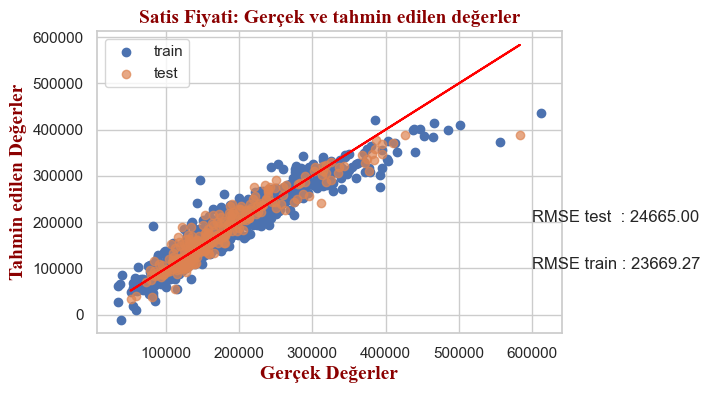

,description,rsquared,MAE,MSE,RMSE,MAPE
model,,,,,,
1,numerik degiskenler,0.867,"19,466.031","803,515,580.766","28,346.350",11.471
2,yuksek korelasyonlu numerik degiskenler,0.803,"24,447.903","1,142,398,277.057","33,799.383",14.919
3,farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular,0.832,"22,988.782","979,299,380.403","31,293.759",14.051
4,etkilesimli(farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular,0.874,"20,523.617","774,342,976.286","27,827.019",12.215
5,butun degiskenler,0.901,"17,458.344","644,190,949.454","25,380.917",10.370
6,butun degiskenlerden anlamli olmayanlar cikarilarak,0.894,"17,214.420","608,362,136.117","24,664.998",10.200


In [25]:
vars_to_remove = []
# p degerleri yuksek olanlari cikar
for var in expl_vars:
    if results.pvalues[var]>0.05:
        vars_to_remove.append(var)
        
# istenmeyenleri ayir
for var in vars_to_remove:
    if var in expl_vars:
        expl_vars.remove(var)       

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()

# test verisi ile tahmin
X_test = sm.add_constant(X_test)
Y_test_pred = results.predict(X_test)
# egitim verisi ile tahmin
X_train = sm.add_constant(X_train)
Y_train_pred = results.predict(X_train)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)

# model sonuclarini kaydedelim
save_results(results, 6, Y_test, Y_test_pred,
             'butun degiskenlerden anlamli olmayanlar cikarilarak')

# model sonuclari
results_df

### ***7. Model Etkilesimli(Butun degiskenlerden anlamli olmayanlar cikarilarak)***

Eğitim kümesindeki gözlem sayısı : 1153
Test kümesindeki gözlem sayısı   : 289


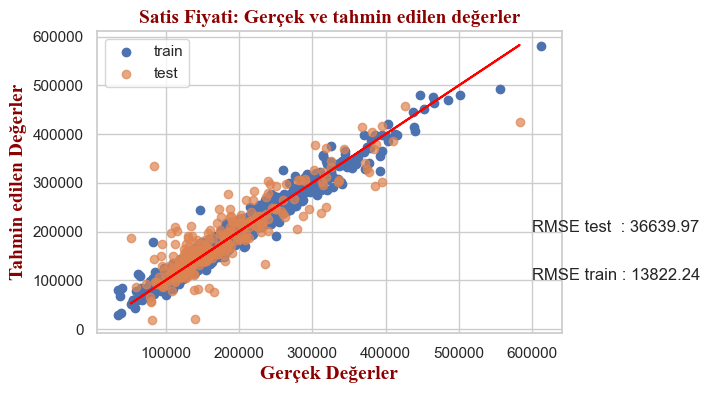

,description,rsquared,MAE,MSE,RMSE,MAPE
model,,,,,,
1,numerik degiskenler,0.867,"19,466.031","803,515,580.766","28,346.350",11.471
2,yuksek korelasyonlu numerik degiskenler,0.803,"24,447.903","1,142,398,277.057","33,799.383",14.919
3,farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular,0.832,"22,988.782","979,299,380.403","31,293.759",14.051
4,etkilesimli(farklilik olusturan kategorik degiskenler ve yuksek korelasyonlular,0.874,"20,523.617","774,342,976.286","27,827.019",12.215
5,butun degiskenler,0.901,"17,458.344","644,190,949.454","25,380.917",10.370
6,butun degiskenlerden anlamli olmayanlar cikarilarak,0.894,"17,214.420","608,362,136.117","24,664.998",10.200
7,etkilesimli(butun degiskenlerden anlamli olmayanlar cikarilarak),0.964,"23,838.889","1,342,487,294.500","36,639.969",15.575


In [26]:
# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# kacinci dereceden polinomlar olusturacagiz belirtiyoruz
poly = PolynomialFeatures(2)
X = poly.fit_transform(X)

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()

# test verisi ile tahmin
X_test = sm.add_constant(X_test)
Y_test_pred = results.predict(X_test)
# egitim verisi ile tahmin
X_train = sm.add_constant(X_train)
Y_train_pred = results.predict(X_train)

# grafigi cizdirelim
make_plot(Y_test, Y_test_pred, Y_train, Y_train_pred)


# 7 inci model sonuclarini kaydedelim
save_results(results,  7, Y_test, Y_test_pred, 
             'etkilesimli(butun degiskenlerden anlamli olmayanlar cikarilarak)')

# 7 inci model sonuclari
results_df

- R-kare ve RMSE sonuclarina bakildiginda en iyi modelin 6 inci model oldugu gorulmektedir.
- Tahmin-gercek deger grafiklerine bakildiginda yuksek fiyatli evlerde aykiri degerler oldugu degerlendirilmektedir. Yeniden aykiri deger tespiti adimina donup temizlik yapildiktan sonra model performansi degerlendirilebilir.